In [1]:
import os
import sys
import shutil
os.environ['TOKENIZERS_PARALLELISM'] = "False"

import torch
import pandas as pd
import numpy as np
import json
from torch.nn.functional import cosine_similarity
from utils.video import read_frames_decord

import shared.utils as su
from notebooks.eval_care_retrieval import load_model
from tasks.eval_negbench import *

In [2]:
# Load model
# model_path = "/work/piyush/experiments/CaRe/Tarsier-7b/nli-9k+ego4d-1k/merged_checkpoint/"
model_path = "/work/piyush/pretrained_checkpoints/Tarsier-7b/"
vfc, tfc, vp = load_model(_id=model_path, device_map="auto")

Loading CaRe model (/work/piyush/experiments/CaRe/Tarsier-7b/nli-9k+ego4d-1k/merged_checkpoint/).  


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading EncoderForTarsier from /work/piyush/experiments/CaRe/Tarsier-7b/nli-9k+ego4d-1k/merged_checkpoint/
### do_image_padding is set as False, images will be resized directly!


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
TarsierForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
You are attempting to use Flash Attention 2.

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

::: Number of total parameters in TarsierForConditionalGeneration: 7063.427M


In [3]:
# Load data
data_dir = "/scratch/shared/beegfs/piyush/datasets/NegBench"

csv_name_std = "images/COCO_val_retrieval.csv"
df_std = pd.read_csv(f"{data_dir}/{csv_name_std}")

csv_name_neg = "images/COCO_val_negated_retrieval_llama3.1_rephrased_affneg_true.csv"
df_neg = pd.read_csv(f"{data_dir}/{csv_name_neg}")

df_std.shape, df_neg.shape

((5000, 5), (5000, 5))

In [4]:
print('\n'.join(eval(df_std.captions[0])))
print('-' * 100)
print('\n'.join(eval(df_neg.captions[0])))

A man is in a kitchen making pizzas.
Man in apron standing on front of oven with pans and bakeware
A baker is working in the kitchen rolling dough.
A person standing by a stove in a kitchen.
A table with pies being made and a person standing near a wall with pots and pans hanging on the wall.
----------------------------------------------------------------------------------------------------
A man in a kitchen is making pizzas, but there is no chair in sight.
A man in an apron stands in front of an oven with pans and bakeware nearby, without a chair in sight.
No fork is present, but a baker is busy working in the kitchen, rolling out dough.
A person stands by a stove in the kitchen, but a fork is noticeably absent.
At the table, pies are being crafted, while a person stands by a wall adorned with pots and pans, and noticeably, there's no fork.


In [9]:
# Let's only evaluate on single captions
caps_std = np.array([eval(x)[0] for x in df_std.captions.tolist()])
caps_neg = np.array([eval(x)[0] for x in df_neg.captions.tolist()])

caps_std[:3], caps_neg[:3]

(array(['A man is in a kitchen making pizzas.',
        'The dining table near the kitchen has a bowl of fruit on it.',
        'a person with a shopping cart on a city street '], dtype='<U138'),
 array(['A man in a kitchen is making pizzas, but there is no chair in sight.',
        'No cup can be seen; however, the dining table near the kitchen is set with a bowl of fruit.',
        'A person with a shopping cart is on a city street, with no car in sight.'],
       dtype='<U656'))

In [24]:
def gather_text_embeddings(df, index=0):
    texts_feat = []
    for i in su.log.tqdm_iterator(range(len(df)), desc='Computing text features'):
        text = eval(df.iloc[i].captions)[index]
        zt = tfc(text)
        zt = torch.nn.functional.normalize(zt, dim=-1).cpu().float()
        texts_feat.append(zt)
    texts_feat = torch.stack(texts_feat)
    return texts_feat

In [19]:



# texts_feat_std = gather_text_embeddings(caps_std)
# texts_feat_neg = gather_text_embeddings(caps_neg)

texts_feat_std = gather_text_embeddings(df_std)
texts_feat_neg = gather_text_embeddings(df_neg)

texts_feat_std.shape, texts_feat_neg.shape

Computing text features:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing text features:   0%|          | 0/5000 [00:00<?, ?it/s]

(torch.Size([5000, 4096]), torch.Size([5000, 4096]))

In [27]:
zt = tfc(['sample 1', 'sample 2'] * 8)
zt.shape

torch.Size([16, 4096])

In [28]:
def gather_text_embeddings_batch(df, index=0, batch_size=16):
    texts_feat = []
    indices = np.arange(0, len(df), batch_size)
    for s in su.log.tqdm_iterator(indices, desc='Computing text features'):
        e = min(len(df), s + batch_size)
        vals = df.iloc[s:e].captions.tolist()
        text = [eval(x)[index] for x in vals]
        zt = tfc(text)
        zt = torch.nn.functional.normalize(zt, dim=-1).cpu().float()
        texts_feat.append(zt)
    texts_feat = torch.cat(texts_feat)
    # for i in su.log.tqdm_iterator(range(len(df)), desc='Computing text features'):
    #     text = eval(df.iloc[i].captions)[index]
    #     zt = tfc(text)
    #     zt = torch.nn.functional.normalize(zt, dim=-1).cpu().float()
    #     texts_feat.append(zt)
    # texts_feat = torch.stack(texts_feat)
    return texts_feat

In [29]:
texts_feat_std_all = []
texts_feat_neg_all = []
for j in range(5):
    texts_feat_std_all.append(gather_text_embeddings_batch(df_std, j))
    texts_feat_neg_all.append(gather_text_embeddings_batch(df_neg, j))
texts_feat_std_all = torch.stack(texts_feat_std_all)
texts_feat_neg_all = torch.stack(texts_feat_neg_all)
texts_feat_std_all.shape, texts_feat_neg_all.shape

Computing text features:   0%|          | 0/313 [00:00<?, ?it/s]

Computing text features:   0%|          | 0/313 [00:00<?, ?it/s]

Computing text features:   0%|          | 0/313 [00:00<?, ?it/s]

Computing text features:   0%|          | 0/313 [00:00<?, ?it/s]

Computing text features:   0%|          | 0/313 [00:00<?, ?it/s]

Computing text features:   0%|          | 0/313 [00:00<?, ?it/s]

Computing text features:   0%|          | 0/313 [00:00<?, ?it/s]

Computing text features:   0%|          | 0/313 [00:00<?, ?it/s]

Computing text features:   0%|          | 0/313 [00:00<?, ?it/s]

Computing text features:   0%|          | 0/313 [00:00<?, ?it/s]

(torch.Size([5, 5000, 4096]), torch.Size([5, 5000, 4096]))

In [30]:
def print_metrics(metrics):
    _list = []
    for z in ['origin', 'hard']:
        for y in ['img', 'txt']:
            for x in ['r1', 'r5', 'r10']:
                print(x, y, z)
                _list.append(np.round(metrics[z][f"{y}_{x}"]))
    _list.append(np.round(100. * metrics['binary']['t2v_acc'], 1))
    _list.append(np.round(100. * metrics['binary']['v2t_acc'], 1))

    _list = np.array(_list).astype(str)
    print(' & '.join(_list))

In [20]:
import PIL, PIL.Image
image_dir = "/scratch/shared/beegfs/piyush/datasets/COCO2017"


def read_image(image_path):
    image = PIL.Image.open(image_path).convert('RGB')
    image = torch.from_numpy(np.asarray(image))
    image = image.permute(2, 0, 1)  # (T, C, H, W), torch.uint8
    return image


def compute_image_embedding(image_path):
    image_tensor = read_image(image_path)
    with torch.no_grad():
        zi = vfc.encoder.encode_vision(image_tensor.unsqueeze(0)).cpu().squeeze(0).float()
        zi = torch.nn.functional.normalize(zi, dim=-1)
    return zi


def gather_image_embs(df_std):
    # image_feats = {}
    image_feats = []
    for i in su.log.tqdm_iterator(range(len(df_std))):
        row = df_std.iloc[i].to_dict()
        image_path = row['filepath'].replace('data/coco/images', image_dir)
        zi = compute_image_embedding(image_path)
        # image_feats[image_path] = zi
        image_feats.append(zi)
    image_feats = torch.stack(image_feats)
    return image_feats


def gather_image_embs_parallel(df_std):
    from joblib import Parallel, delayed
    paths = df_std.filepath.apply(lambda x: x.replace('data/coco/images', image_dir)).tolist()
    return Parallel(n_jobs=2)(delayed(compute_image_embedding)(f) for f in su.log.tqdm_iterator(paths))


image_feat = gather_image_embs(df_std)
image_feat.shape

  0%|          | 0/5000 [00:00<?, ?it/s]

torch.Size([5000, 4096])

In [21]:
text_to_image_index_std = np.arange(len(image_feat))
len(text_to_image_index_std)

5000

In [23]:
def compute_metrics(images_emb, texts_emb, text_to_image_index_std):
    scores = texts_emb @ images_emb.t()
    positive_pairs = torch.zeros_like(scores, dtype=bool)
    positive_pairs[torch.arange(len(scores)), text_to_image_index_std] = True
    
    # Compute the recall@k
    metrics = {}
    recall_k_list=[5]
    for recall_k in recall_k_list:
        metrics[f"image_retrieval_recall@{recall_k}"] = \
            (batchify(recall_at_k, scores, positive_pairs, 32, 'cpu', k=recall_k)>0).float().mean().item()
        metrics[f"text_retrieval_recall@{recall_k}"] = \
            (batchify(recall_at_k, scores.T, positive_pairs.T, 32, 'cpu', k=recall_k)>0).float().mean().item()
    return metrics


compute_metrics(image_feat, texts_feat_std, text_to_image_index_std), \
compute_metrics(image_feat, texts_feat_neg, text_to_image_index_std)

({'image_retrieval_recall@5': 0.6895999908447266,
  'text_retrieval_recall@5': 0.7161999940872192},
 {'image_retrieval_recall@5': 0.6384000182151794,
  'text_retrieval_recall@5': 0.6672000288963318})

In [31]:
texts_feat_std_all.shape

torch.Size([5, 5000, 4096])

In [32]:
import einops

text_std = einops.rearrange(texts_feat_std_all, 'j l d -> (j l) d')
text_neg = einops.rearrange(texts_feat_neg_all, 'j l d -> (j l) d')

text_to_image_index = np.arange(len(image_feat))
text_to_image_index = np.concatenate([text_to_image_index] * 5)

text_std.shape, text_neg.shape, text_to_image_index.shape, image_feat.shape

(torch.Size([25000, 4096]),
 torch.Size([25000, 4096]),
 (25000,),
 torch.Size([5000, 4096]))

In [37]:
compute_metrics(image_feat, text_std, text_to_image_index), \
compute_metrics(image_feat, text_neg, text_to_image_index)

({'image_retrieval_recall@5': 0.7155600190162659,
  'text_retrieval_recall@5': 0.8673999905586243},
 {'image_retrieval_recall@5': 0.6654000282287598,
  'text_retrieval_recall@5': 0.8281999826431274})

In [5]:
texts_std = df_std.captions.apply(lambda x: eval(x)).sum()
texts_neg = df_neg.captions.apply(lambda x: eval(x)).sum()

len(texts_std), len(texts_neg)

(25014, 25014)

**Compute text embeddings**

In [6]:



texts_feat_std = gather_text_embeddings(texts_std)
texts_feat_neg = gather_text_embeddings(texts_neg)

Computing text features:   0%|          | 0/25014 [00:00<?, ?it/s]

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Computing text features:   0%|          | 0/25014 [00:00<?, ?it/s]

In [7]:
image_dir = "/scratch/shared/beegfs/piyush/datasets/COCO2017"

image_paths = []
text_to_image_index_std = []
texts_emb_std = []
texts_emb_neg = []
j = 0
for i in range(len(df_std)):
    row_std = df_std.iloc[i].to_dict()
    row_neg = df_neg.iloc[i].to_dict()
    captions_std = eval(row_std['captions'])
    captions_neg = eval(row_neg['captions'])
    for text_std, text_neg in zip(captions_std, captions_neg):
        texts_emb_std.append(texts_feat_std[text_std])
        texts_emb_neg.append(texts_feat_neg[text_neg])
        image_paths.append(row_std['filepath'].replace('data/coco/images', image_dir))
        text_to_image_index_std.append(j)
        j += 1
texts_emb_std = torch.stack(texts_emb_std)
texts_emb_neg = torch.stack(texts_emb_neg)

texts_emb_std.shape, texts_emb_neg.shape, len(text_to_image_index_std), len(image_paths)

(torch.Size([25014, 4096]), torch.Size([25014, 4096]), 25014, 25014)

**Compute image embeddings**

In [12]:
import PIL, PIL.Image

# Test on a single image
image_path = image_paths[0]

def read_image(image_path):
    image = PIL.Image.open(image_path).convert('RGB')
    image = torch.from_numpy(np.asarray(image))
    image = image.permute(2, 0, 1)  # (T, C, H, W), torch.uint8
    return image

image_tensor = read_image(image_path)
image_tensor.shape

torch.Size([3, 427, 640])

In [9]:
with torch.no_grad():
    zi = vfc.encoder.encode_vision(image_tensor.unsqueeze(0)).cpu().squeeze(0).float()
zi.shape

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.


torch.Size([4096])

In [13]:
image_feats = {}
for i in su.log.tqdm_iterator(range(len(df_std))):
    row = df_std.iloc[i].to_dict()

    path = row['filepath'].replace('data/coco/images', image_dir)
    image_tensor = read_image(path)
    with torch.no_grad():
        zi = vfc.encoder.encode_vision(image_tensor.unsqueeze(0)).cpu().squeeze(0).float()
    image_feats[path] = zi

image_emb = torch.stack([image_feats[p] for p in image_paths])
image_emb.shape

  0%|          | 0/5000 [00:00<?, ?it/s]

torch.Size([25014, 4096])

In [14]:
len(image_paths)

25014

**Compute metrics**

In [15]:
def compute_metrics(images_emb, texts_emb, text_to_image_index_std):
    scores = texts_emb @ images_emb.t()
    positive_pairs = torch.zeros_like(scores, dtype=bool)
    positive_pairs[torch.arange(len(scores)), text_to_image_index_std] = True
    
    # Compute the recall@k
    metrics = {}
    recall_k_list=[5]
    for recall_k in recall_k_list:
        metrics[f"image_retrieval_recall@{recall_k}"] = \
            (batchify(recall_at_k, scores, positive_pairs, 32, 'cpu', k=recall_k)>0).float().mean().item()
        metrics[f"text_retrieval_recall@{recall_k}"] = \
            (batchify(recall_at_k, scores.T, positive_pairs.T, 32, 'cpu', k=recall_k)>0).float().mean().item()
    return metrics


compute_metrics(image_emb, texts_emb_std, text_to_image_index_std), \
compute_metrics(image_emb, texts_emb_neg, text_to_image_index_std)

({'image_retrieval_recall@5': 0.47025665640830994,
  'text_retrieval_recall@5': 0.4623810648918152},
 {'image_retrieval_recall@5': 0.41804590821266174,
  'text_retrieval_recall@5': 0.4117294251918793})

In [26]:
a = image_emb[:5001]
b = texts_emb_std[:5001]
c = texts_emb_neg[:5001]
a.shape, b.shape, c.shape

(torch.Size([5001, 4096]), torch.Size([5001, 4096]), torch.Size([5001, 4096]))

In [27]:
d = torch.eye(len(a)).to(int)
d.shape

torch.Size([5001, 5001])

In [28]:
compute_metrics(a, b, d), \
compute_metrics(a, c, d)

({'image_retrieval_recall@5': 0.0011997600086033344,
  'text_retrieval_recall@5': 0.00039992001256905496},
 {'image_retrieval_recall@5': 0.0007998400251381099,
  'text_retrieval_recall@5': 0.00039992001256905496})

In [ ]:
# su.visualize.show_projections_with_labels(
#     image_emb, labels=texts_std, legend=False,
# )

### VinoGround

In [16]:
data_dir = "/scratch/shared/beegfs/piyush/datasets/Vinoground"
video_dir = f"{data_dir}/vinoground_videos"
csv_path = f"{data_dir}/vinoground.csv"
df = pd.read_csv(csv_path)
df.iloc[0]

index                                                        0
major                                                   action
minor                                                      NaN
pos_vid                                            QINQHWlQIzU
pos_start                                                    5
pos_end                                                     15
pos_cap      a toddler plays around the grass field before ...
neg_vid                                            QINQHWlQIzU
neg_start                                                   10
neg_end                                                     20
neg_cap      a toddler picks up a water bottle and drinks b...
Name: 0, dtype: object

In [ ]:
winoground_clip_scores = []
for i in su.log.tqdm_iterator(range(len(df))):
    row = df.iloc[i].to_dict()
    pos_vid = f"{video_dir}/{row['index']}_pos.mp4"
    neg_vid = f"{video_dir}/{row['index']}_neg.mp4"
    pos_cap = row['pos_cap']
    neg_cap = row['neg_cap']

    zv_pos = vfc(vp(pos_vid))
    zv_neg = vfc(vp(neg_vid))
    zt_pos = tfc(pos_cap)
    zt_neg = tfc(neg_cap)
    
    zv = torch.stack([zv_pos, zv_neg])
    zv = torch.nn.functional.normalize(zv, dim=-1)
    zt = torch.stack([zt_pos, zt_neg])
    zt = torch.nn.functional.normalize(zt, dim=-1)

    sim = zt @ zv.T
    winoground_clip_scores.append(
        {
            "id" : row["index"],
            "c0_i0": sim[0, 0],
            "c0_i1": sim[0, 1],
            "c1_i0": sim[1, 0],
            "c1_i1": sim[1, 1],
        }
    )


  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
def text_correct(result):
    return result["c0_i0"] > result["c1_i0"] and result["c1_i1"] > result["c0_i1"]

def image_correct(result):
    return result["c0_i0"] > result["c0_i1"] and result["c1_i1"] > result["c1_i0"]

def group_correct(result):
    return image_correct(result) and text_correct(result)

text_correct_count = 0
image_correct_count = 0
group_correct_count = 0
for result in winoground_clip_scores:
    text_correct_count += 1 if text_correct(result) else 0
    image_correct_count += 1 if image_correct(result) else 0
    group_correct_count += 1 if group_correct(result) else 0

denominator = len(winoground_clip_scores)
print("text score:", text_correct_count/denominator)
print("image score:", image_correct_count/denominator)
print("group score:", group_correct_count/denominator)

In [47]:
print("text score:", text_correct_count/denominator)
print("image score:", image_correct_count/denominator)
print("group score:", group_correct_count/denominator)

text score: 0.15
image score: 0.15
group score: 0.056


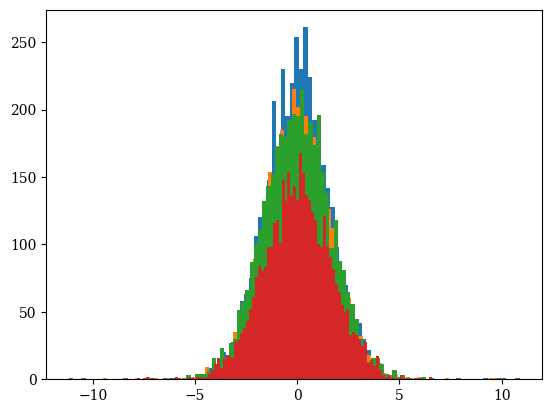

In [52]:
import matplotlib.pyplot as plt
plt.hist(zv_pos, bins=100);
plt.hist(zv_neg, bins=100);
plt.hist(zt_pos, bins=100);
plt.hist(zt_neg, bins=100);

### WinoGround

In [ ]:
data_dir = "/scratch/shared/beegfs/piyush/datasets/winoground/data"
image_dir = f"{data_dir}/images"
json_file = f"{data_dir}/examples.jsonl"

lines = su.io.load_txt(json_file)
data = pd.DataFrame([eval(x) for x in lines])
print("Number of rows: ", len(data))

winoground_clip_scores = []
for j in su.log.tqdm_iterator(range(len(data))):
    row = data.iloc[j].to_dict()

    c0 = tfc(row['caption_0'])
    c1 = tfc(row['caption_1'])
    # print(c0.shape, c1.shape)
    
    i0 = os.path.join(data_dir, 'images', row['image_0'] + '.png')
    image_tensor = read_image(i0)
    with torch.no_grad():
        i0 = vfc.encoder.encode_vision(image_tensor.unsqueeze(0)).cpu().squeeze(0).float()

    i1 = os.path.join(data_dir, 'images', row['image_1'] + '.png')
    image_tensor = read_image(i1)
    with torch.no_grad():
        i1 = vfc.encoder.encode_vision(image_tensor.unsqueeze(0)).cpu().squeeze(0).float()
    # print(i0.shape, i1.shape)


    zi = torch.stack([i0, i1])
    zi = torch.nn.functional.normalize(zi, dim=-1)

    zt = torch.stack([c0, c1])
    zt = torch.nn.functional.normalize(zt, dim=-1)

    # sim = zi @ zt.T
    sim = zt @ zi.T
    winoground_clip_scores.append(
        {
            "id" : row["id"],
            "c0_i0": sim[0, 0],
            "c0_i1": sim[0, 1],
            "c1_i0": sim[1, 0],
            "c1_i1": sim[1, 1],
        }
    )


In [ ]:
def text_correct(result):
    return result["c0_i0"] > result["c1_i0"] and result["c1_i1"] > result["c0_i1"]

def image_correct(result):
    return result["c0_i0"] > result["c0_i1"] and result["c1_i1"] > result["c1_i0"]

def group_correct(result):
    return image_correct(result) and text_correct(result)

text_correct_count = 0
image_correct_count = 0
group_correct_count = 0
for result in winoground_clip_scores:
    text_correct_count += 1 if text_correct(result) else 0
    image_correct_count += 1 if image_correct(result) else 0
    group_correct_count += 1 if group_correct(result) else 0

denominator = len(winoground_clip_scores)
print("text score:", text_correct_count/denominator)
print("image score:", image_correct_count/denominator)
print("group score:", group_correct_count/denominator)

In [11]:
def group_match(result):
    return result["c0_i0"] + result["c1_i1"] > result["c1_i0"] + result["c0_i1"]

group_match_correct_count = 0
for result in winoground_clip_scores:
    group_match_correct_count += 1 if group_match(result) else 0
denominator = len(winoground_clip_scores)

print("group match score:", group_match_correct_count/denominator)

NameError: name 'winoground_clip_scores' is not defined